In [105]:
import numpy as np
import pandas as pd
import slopeOP as sop
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

from slopeop_simulation import *

from plotting_nice import savefig

In [106]:
from matplotlib import rcParams as rcp
from matplotlib import axis
rcp['lines.linewidth'] = 2
rcp['font.size'] = 18
rcp['legend.fontsize'] = 16

def set_standard_yrange(axs=None, xrange=None, yrange=(-100,150)):
    """Set x and y ranges fot the given axis or list of axis"""
    if axs is None: axs=plt.gca()
    try:
        iter(axs)
    except TypeError:
        if xrange is not None: axs.set_xlim(xrange)
        if yrange is not None: axs.set_ylim(yrange)
    else:
        for ax in axs:
            if xrange is not None: ax.set_xbound(yrange)
            if yrange is not None: ax.set_ybound(yrange)

# SlopeOP simulations
This notebooks runs the simulations presented in the paper *Efficient Change-in-Slope Optimal Partitioning Algorithm in a Finite-Size Parameter Space* by V.Runge et Al.

The notebook consists of 3 patrs:

1. **Data generation**, where we generate four different signals and add Gaussian noise
2. **Segmentation**, where we segment the noisy simulated signals with SlopeOP and other algorythms
3. **Figures**, where we generate the figures shown in the paper.

## 1. Data generation

Here we generate the four simulated signals. The i-th signal is generated by the corresponding function *signal_i(sigma=0, seed=0)* where sigma is the std if optional added random Gaussian noise and seed is the initialization value of the pseudo-random function which generates noise.
Each function returns a signal of 500 samples.

In [107]:
# Plot the four simulation signals (noiseless)
fig, ax = plt.subplots(1,4,figsize=(15,3))

ax[0].plot(signal_1()); ax[0].set_title("signal 1")
ax[1].plot(signal_2()); ax[1].set_title("signal 2")
ax[2].plot(signal_3()); ax[2].set_title("signal 3")
ax[3].plot(signal_4()); ax[3].set_title("signal 4");

set_standard_yrange(ax)

### Adding noise

Here, Gaussian noise is added to the signals. The noise has zero mean and std=3,12,24

For each value of std, we generate 10 different random noises by setting a different seed (from 0 to 9).
In this way we generate 31 different noisy signal (3 sigma x 10 seeds + the original signal).

In [108]:
# Variable initialization
seeds = np.arange(1,11)
sigmas = np.array([3,12,24])

# Loop over each signal
for f in [signal_1, signal_2, signal_3, signal_4,signal_1_at_50pt, signal_1_at_300pt]:
    
    signal={}

    column_format = "{sigma}_{seed}"
    column_name = column_format.format(sigma=0, seed=0)
    signal[column_name] = f(noise=0)
    
    for sigma in sigmas:
        for seed in seeds:
            column_name = column_format.format(sigma=sigma, seed=seed)
            signal[column_name] = f(noise=sigma,seed=seed)

    # Write data
    file_name = f"{f.__name__}.csv"
    pd.DataFrame(signal).to_csv(file_name, index=False)

The code-cell above writes in the working folder four CSV files containing the 301 noisy variations of each segnal:

signal_1.csv, signal_2.csv, signal_3.csv, signal_4.csv

The different noisy signals are stored as columns.
The CSV file has 500 lines (corresponding to the signal samples)

In [109]:
signal3_csv = pd.read_csv("signal_3.csv")
print("CSV file dimensions:", signal3_csv.shape)

CSV file dimensions: (500, 31)


The column name indicates the std and the seed for that column (in the format std_seed)

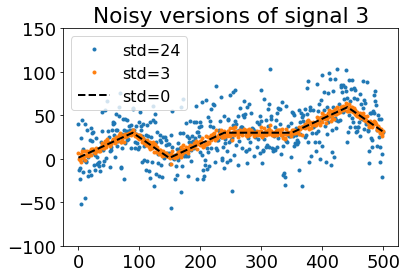

In [110]:
plt.plot(signal3_csv['24_1'],'.', label="std=24")
plt.plot(signal3_csv['3_1'],'.', label="std=3")
plt.plot(signal3_csv['0_0'], '--k', label="std=0")
plt.legend()
plt.title("Noisy versions of signal 3")

set_standard_yrange()

## 2. Segmentation of the simulated signals

Per each noisy signal we calculate the optimal segmentation with the different algorithms as explained in the Paper.

In [112]:
# Preparation of the segmentation batch
# print(*run_list, sep='\n')

run_list = []

## Data for Figure 2
run_list += get_run_list(algos = ['SlopeOP','FPOP','RFPOP'],
    signals = ['signal_1.csv', 'signal_1_at_50pt.csv', 'signal_1_at_300pt.csv'],
    betas = np.arange(0.1,5.1,0.1)
)

## Data for Figure 4 and 10
run_list += get_run_list(algos = ['CPOP','OP2D'],
    signals = ["signal_1.csv", "signal_2.csv", "signal_3.csv", "signal_4.csv"],
    betas = np.arange(0.1,5.1,0.1)
)

run_list += get_run_list(algos = ['SlopeOP'],
    signals = ["signal_2.csv", "signal_3.csv", "signal_4.csv"],
    betas = np.arange(0.1,5.1,0.1)
)



print(len(run_list), "simulation files will be generated")

1000 simulation files will be generated


In [98]:
## GENERATES DIMULATION FILES ARE STORED IN THE SlopeOP_simulations_data.7z ARCHIVE
## Please decompress this archive in the same folder of this notebook in order to
## run the following analysis.

## UNCOMMENT THIS CODE TO ACTUALLY RUN THE SIMULATION AND GENERATE SIMULATION FILES
batch_size = 4 # Number of parallel processes
batch_time = []
for i_from in tqdm(range(0,len(run_list),batch_size)): 
    i_to = i_from + batch_size
    if len(batch_time) == 0:
        avtime = 0
    else:
        avtime = np.average(batch_time)
#     tqdm.write(f"working on batch {i_from}:{i_to} - av. batch time: {avtime/60:.0f}min")
    tic = time.time()
    await simulation_run(run_list[i_from:i_to])
    toc = time.time()
    batch_time.append(toc-tic)

100%|██████████| 138/138 [1:48:03<00:00, 46.98s/it] 


In [99]:
# plot one column
column = "12_5"
signal="signal_3"
algo='OP2D'
beta=1.500

original_signal = pd.read_csv(f"{signal}.csv")
algo_signal = pd.read_csv(f"simu_{signal}_{algo}_{beta:.3f}.csv")

cn = column

def plot_picewise_linear(y,*args, **kwargs):
    """plot a piecewise linear signal as disconnected segments"""
    segs=get_linear_segments(y)
    label=kwargs.pop('label',None)
    
    for s in segs[:-1]:
        plot(s,*args,**kwargs)
    
    plot(segs[-1],*args,**kwargs,label=label)



plt.plot(original_signal[cn], '.', label="signal")
plot_picewise_linear(algo_signal[f"X{cn}"],'k', label="segmentation")
plt.legend();
plt.ylabel("signal")
plt.xlabel("time")
plt.title("Segmentation of a noisy signal")

set_standard_yrange()

## 3. Analysus and figures

We analyze the segemntation results and generate Figures : fig2, fig4, fig1.5, fig1.10 of the paper

### Figure 2

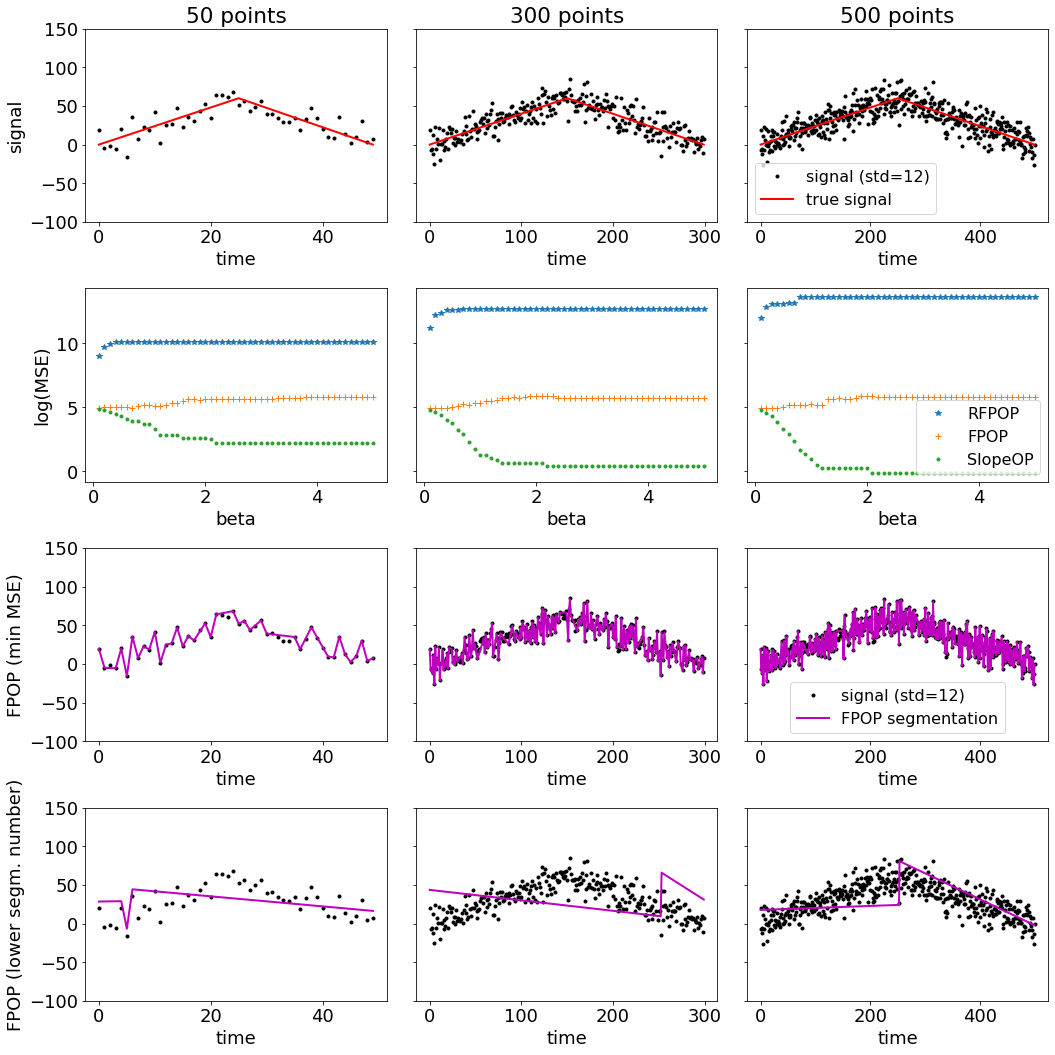

In [100]:
## ANALYSIS
def get_mse_vs_beta(signal_name, algo, betas, sigma, seeds=np.arange(1,11)):
    """Return the MSE vs Beta of a given segmentation algorithm,
    averaged over the different noise realizations"""
    mses = np.zeros(len(betas))
    for i,beta in enumerate(betas):
        signal_data = pd.read_csv(f"simu_{signal_name}_{algo}_{beta:.3f}.csv")
        mse_temp = []
        for seed in seeds:
            mse_temp.append(mse(signal_data["X0_0"], signal_data[f"X{sigma}_{seed}"]))
        mses[i] = np.mean(mse_temp)
    return np.log(mses)

def get_mses(signal_name, algo, beta, sigma, seeds=np.arange(1,11)):
    """Return the RMSEs of a given segmentation algorithm,
    for all different noise realizations"""
    mses = []
    signal_data = pd.read_csv(f"simu_{signal_name}_{algo}_{beta:.3f}.csv")
    for seed in seeds:
        mses.append(mse(signal_data["X0_0"], signal_data[f"X{sigma}_{seed}"]))
    return mses

marker_algo = {
    'SlopeOP': '.',
    'CPOP': '+',
    'OP2D': '*',
    'FPOP': '+',
    'RFPOP': '*'
}

fig, axs = plt.subplots(4,3, figsize=(15,15), sharey='row')

## FIRST ROW OF SUBPLOTS
signals = ("signal_1_at_50pt","signal_1_at_300pt","signal_1")
labels = (50,300,500)
for signal, ax, label in zip(signals, axs[0], labels):
    original_signal = pd.read_csv(f"{signal}.csv")
    ax.plot(original_signal["12_1"], 'k.', label=f"signal (std=12)")
    ax.plot(original_signal["0_0"],'r',label=f"true signal")
    ax.set_xlabel('time')
    ax.set_title(f"{label} points")
    
axs[0,2].legend(loc='lower left')
axs[0,0].set_ylabel('signal')
set_standard_yrange(axs[0,0])


## SECOND ROW OF SUBPLOTS
signals = ["signal_1_at_50pt", "signal_1_at_300pt", "signal_1"]
betas = np.arange(0.1,5.1,0.1)
for i, signal in enumerate(signals):
    original_signal = pd.read_csv(f"{signal}.csv")
    datas = {
        'RFPOP': get_mse_vs_beta(signal, "RFPOP", betas, 12),
        'FPOP': get_mse_vs_beta(signal, "FPOP", betas, 12),
        'SlopeOP': get_mse_vs_beta(signal, "SlopeOP", betas, 12),
    }
    
    for algo in datas:
        axs[1,i].plot(betas, datas[algo], linewidth=0, marker=marker_algo[algo], label=algo)
        axs[1,i].set_xlabel("beta")

axs[1,0].set_ylabel("log(MSE)")
axs[1,2].legend(loc="lower right")
    
## TIRD ROW OF SUBPLOTS
signals = ["signal_1_at_50pt", "signal_1_at_300pt", "signal_1"]
algo = "FPOP"
beta = 0.1

for i, signal in enumerate(signals):
    signal = signal
    original_signal = pd.read_csv(f"{signal}.csv")["12_1"]
    fpop_signal = pd.read_csv(f"simu_{signal}_{algo}_{beta:.3f}.csv")
    axs[2,i].plot(original_signal, 'k.', label=f"signal (std=12)")
    axs[2,i].plot(fpop_signal["X12_1"], 'm-', label="FPOP segmentation")
    axs[2,i].set_xlabel('time')

axs[2,0].set_ylabel('FPOP (min MSE)')
axs[2,2].legend(loc='lower left')
set_standard_yrange(axs[2,0])


    
# Fourth row
signals = ["signal_1_at_50pt", "signal_1_at_300pt", "signal_1"]
algo = "FPOP"
beta = 1.8

for i, signal in enumerate(signals):
    signal = signal
    original_signal = pd.read_csv(f"{signal}.csv")["12_1"]
    fpop_signal = pd.read_csv(f"simu_{signal}_{algo}_{beta:.3f}.csv")
    axs[3,i].plot(original_signal, 'k.', label=f"signal (sd=12)")
    axs[3,i].plot(fpop_signal["X12_1"], 'm-', label="FPOP segmentation")
    axs[3,i].set_xlabel('time')


axs[3,0].set_ylabel('FPOP (lower segm. number)')
axs[2,2].legend()
set_standard_yrange(axs[3,0])

savefig(f"Figures/fpop-justification.pdf")


### Figure 3

In [101]:
fig, axs = plt.subplots(3,4, figsize=(15,9), sharey=True, sharex=True)
signals = ["signal_1", "signal_2", "signal_3", "signal_4"]
sigmas = ["3", "12", "24"]

for i, sigma in enumerate(sigmas):
    for j, signal in enumerate(signals):
        data = pd.read_csv(f"{signal}.csv")
        without_noise = np.array(data["0_0"])
        with_noise = np.array(data[f"{sigma}_1"])
        axs[i,j].scatter(range(len(with_noise)), with_noise, c='k',s=0.5, label="noisy signal")
        axs[i,j].plot(without_noise,'r', label="true signal")

axs[0,0].set_ylabel("$\sigma = 3$", size=16)
axs[1,0].set_ylabel("$\sigma = 12$", size=16)
axs[2,0].set_ylabel("$\sigma = 24$", size=16)



axs[0,0].legend(loc='lower left')

for i in range(4):
    axs[0,i].set_title("SCENARIO " + str(i+1))
        
fig.text(0.5, 0.0, 'time', ha='center',size=18)
# fig.text(0.04, 0.5, 'signals', va='center', rotation='vertical',size=18)

set_standard_yrange(axs.ravel())

savefig("Figures/simulated-signals.pdf")

### Figures 4 and 10

Change the value of *sigma* here to reproduce figures 4 and 10

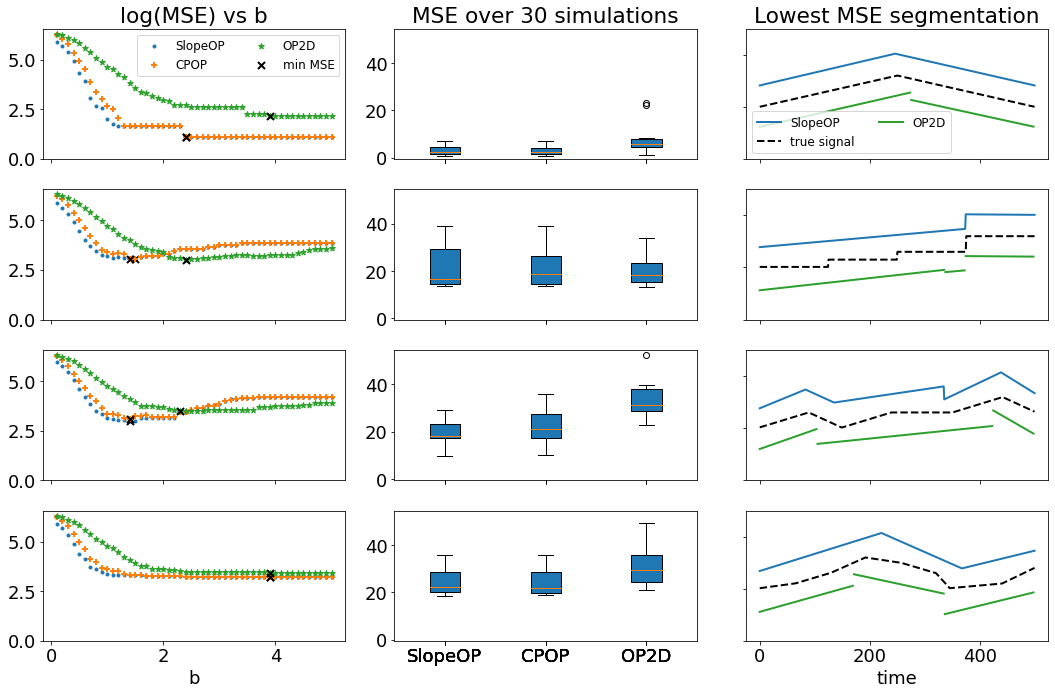

In [104]:
fig, axs = plt.subplots(4,3, figsize=(15,10), sharex='col')
signals = ["signal_1", "signal_2", "signal_3", "signal_4"]
betas = np.arange(0.1,5.1,0.1)
sigma=24

for i, signal in enumerate(signals):
    
    data_col1 = {
    'SlopeOP': get_mse_vs_beta(signal, "SlopeOP", betas, sigma),
    'CPOP': get_mse_vs_beta(signal, "CPOP", betas, sigma),
    'OP2D': get_mse_vs_beta(signal, "OP2D", betas, sigma)
    }
    data_col2={}
    minMSEs = {}
    
    #### Column 1
    original_signal = pd.read_csv(f"{signal}.csv")
    
    for algo in data_col1:
        axs[i,0].scatter(betas, data_col1[algo], marker=marker_algo[algo], label=algo)    
        MSE_argmin = np.argmin(data_col1[algo])
        MSE_min = data_col1[algo][MSE_argmin]
        MSE_min_beta = betas[MSE_argmin]
        minMSEs[algo] = (round(MSE_min_beta,1),MSE_min)
        
        if i == 0 and algo=="OP2D":
            axs[i,0].scatter(MSE_min_beta,MSE_min, s=50, c='k', marker='x', label="min MSE") 
        else:
            axs[i,0].scatter(MSE_min_beta,MSE_min, s=50, c='k', marker='x')    
    
    #### Column 2
        data_col2[algo] = np.array(get_mses(signal, algo, round(MSE_min_beta,1), sigma))
    
    axs[i,1].boxplot(data_col2.values(),patch_artist=True, labels=data_col2.keys())
    
    #### Column 3
    shift=40
    data = pd.read_csv(f"simu_{signal}_SlopeOP_{minMSEs['SlopeOP'][0]:.3f}.csv")[f"X{sigma}_1"]+shift
    axs[i,2].plot(data, label='SlopeOP')
    data = pd.read_csv(f"{signal}.csv")["0_0"]
    axs[i,2].plot(data, 'k--', label='true signal')
    data = pd.read_csv(f"simu_{signal}_OP2D_{minMSEs['OP2D'][0]:.3f}.csv")[f"X{sigma}_1"]-shift
    plt.sca(axs[i,2])
    plot_picewise_linear(data, 'C2', label='OP2D')


        
# axs[0,0].get_shared_x_axes().join((axs[i,0] for i in range(0,4)))
for i in range(4):
    axs[i,2].set_yticklabels([])

axs[-1,0].set_xlabel("b")
axs[-1,-1].set_xlabel("time")

# set optimal yrange
yrange_cols=[[0,0],[0,0]]
for i in range(0,2):
    for ax in axs[:,i]:
        temp=ax.get_ybound()
        if temp[0] < yrange_cols[i][0]:
            yrange_cols[i][0]=temp[0]
        if temp[1] > yrange_cols[i][1]:
            yrange_cols[i][1]=temp[1]


set_standard_yrange(axs[:,2])
set_standard_yrange(axs[:,0], yrange=yrange_cols[0], xrange=None)
set_standard_yrange(axs[:,1], yrange=yrange_cols[1], xrange=None)

axs[0,0].set_title("log(MSE) vs b")
axs[0,1].set_title("MSE over 30 simulations")
axs[0,2].set_title("Lowest MSE segmentation")


axs[0,0].legend(loc="upper right", prop={'size': 12}, ncol=2)
axs[0,2].legend(loc='lower left', prop={'size': 12}, ncol=2)

savefig(f"Figures/beta-mse-boxplots_sigma{sigma}.pdf")